# Eng to French Translation using Deep Learning and Transformers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Input,LSTM, Dense, Embedding, Attention
from keras.layers import TimeDistributed, RepeatVector,Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
import re
import string
from unicodedata import normalize

ModuleNotFoundError: No module named 'keras.preprocessing.text'

**Load Dataset**

In [2]:
def load_dataset(filepath):
    df = pd.read_csv(filepath,encoding='utf-8')
    print("Number of records:",len(df))
    return df

In [3]:
df = load_dataset(r'/kaggle/input/language-translation-englishfrench/eng_-french.csv')
df.head()

Number of records: 175621


,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


# Method 1: Deep Learning

**Data Pre-processing**

In [4]:
def preprocess_text(text):
    # normalize unicode characters
    text = normalize('NFD',text).encode("ascii","ignore")
    text = text.decode("UTF-8")
    # convert to string
    text = str(text)
    # convert to lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove non-printable chars from text
    re_print = re.compile('[^%s]'% re.escape(string.printable))
    text = re_print.sub('',text)
    # remove numbers
    text = re.sub(r'[\d]+','',text)
    # remove multiple spaces
    text = ' '.join(text.split())
    return text

In [5]:
df_copy = df.copy()
df_copy['English words/sentences'] = df_copy.loc[:,'English words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy['French words/sentences'] = df_copy.loc[:,'French words/sentences'].apply(
    lambda x:preprocess_text(x))
df_copy.head()

,English words/sentences,French words/sentences
0,hi,salut
1,run,cours
2,run,courez
3,who,qui
4,wow,ca alors


**Tokenizing data**

In [6]:
def tokenize(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    return tokenizer

In [7]:
# English tokenizer

eng_tokenizer = tokenize(df_copy['English words/sentences'])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

# French tokenizer
fr_tokenizer = tokenize(df_copy['French words/sentences'])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# Sequences
seq_eng = eng_tokenizer.texts_to_sequences(df_copy['English words/sentences'])
seq_fr = fr_tokenizer.texts_to_sequences(df_copy['French words/sentences'])

# Padding
max_length = max([len(seq) for seq in seq_eng + seq_fr])
seq_eng_final = pad_sequences(seq_eng,maxlen=max_length,padding="post")
seq_fr_final = pad_sequences(seq_fr,maxlen=max_length,padding="post")

print("English Vocab Size:",eng_vocab_size)
print("French Vocab Size:",fr_vocab_size)
print("Maximum length of sequences:",max_length)

English Vocab Size: 14407
French Vocab Size: 28133
Maximum length of sequences: 55


**Train/Test Split**

In [8]:
X_train,X_test,y_train,y_test = train_test_split(seq_eng_final,
                                                 seq_fr_final,
                                                 test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((140496, 55), (35125, 55), (140496, 55), (35125, 55))

**Model Building - Functional**

In [9]:
vector_length = 100

# Encoder
enc_inputs = Input(shape=(max_length,))
enc_embedding = Embedding(input_dim=eng_vocab_size,output_dim=vector_length)(enc_inputs)
enc_LSTM = LSTM(256,return_state=True)
enc_output,h,c = enc_LSTM(enc_embedding)
enc_states = [h,c]

# Decoder
dec_inputs = Input(shape=(max_length,))
dec_embedding = Embedding(input_dim=fr_vocab_size,output_dim=vector_length)(dec_inputs)
dec_LSTM = LSTM(256,return_sequences=True,return_state=True)
dec_output,_,_ = dec_LSTM(dec_embedding,initial_state=enc_states)


dec_dense = Dense(fr_vocab_size,activation="softmax")
output = dec_dense(dec_output)

# Model
model = Model([enc_inputs,dec_inputs],output)

# Compile Model
model.compile(optimizer='adam',loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [10]:
# Model training

model.fit([X_train,X_train],y_train,epochs=2,validation_data=([X_test,X_test],y_test))

Epoch 1/2
4391/4391 [==============================] - 368s 82ms/step - loss: 0.7468 - accuracy: 0.8985 - val_loss: 0.6082 - val_accuracy: 0.9073
Epoch 2/2
4391/4391 [==============================] - 349s 79ms/step - loss: 0.5428 - accuracy: 0.9117 - val_loss: 0.5179 - val_accuracy: 0.9142


**Model Building - Sequential**

In [11]:
vector_length = 100
model = Sequential()
model.add(Embedding(input_dim=eng_vocab_size,output_dim=vector_length,input_length=max_length,mask_zero=True))
model.add(Bidirectional(LSTM(256)))
model.add(RepeatVector(max_length))
model.add(LSTM(256,return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size,activation="softmax")))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 100)           1440700   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 55, 512)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 55, 256)           787456    
                                                                 
 time_distributed (TimeDistr  (None, 55, 28133)        7230181   
 ibuted)                                                         
                                                        

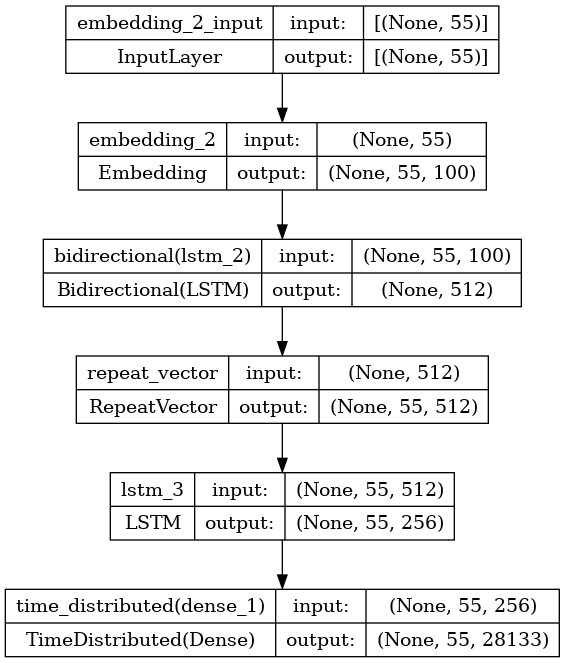

In [12]:
plot_model(model,to_file="model.png",show_shapes=True)

In [13]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
4391/4391 [==============================] - 501s 112ms/step - loss: 0.8344 - accuracy: 0.8896 - val_loss: 0.7202 - val_accuracy: 0.8974
Epoch 2/5
4391/4391 [==============================] - 485s 110ms/step - loss: 0.6514 - accuracy: 0.9030 - val_loss: 0.6000 - val_accuracy: 0.9076
Epoch 3/5
4391/4391 [==============================] - 483s 110ms/step - loss: 0.5313 - accuracy: 0.9119 - val_loss: 0.5098 - val_accuracy: 0.9144
Epoch 4/5
4391/4391 [==============================] - 480s 109ms/step - loss: 0.4418 - accuracy: 0.9183 - val_loss: 0.4571 - val_accuracy: 0.9185
Epoch 5/5
4391/4391 [==============================] - 481s 109ms/step - loss: 0.3783 - accuracy: 0.9235 - val_loss: 0.4248 - val_accuracy: 0.9220


**Predictions**

In [14]:
def translation(input_sentence):
    input_sentence = preprocess_text(str(input_sentence))
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq_final = pad_sequences(input_seq,maxlen=max_length,padding="post")
    prediction = model.predict([input_seq_final])
    output_translation = np.argmax(prediction,axis=-1)
    
    output_sentence = []
    for i in output_translation[0]:
        if i in fr_tokenizer.index_word:
            output_sentence.append(fr_tokenizer.index_word[i])
        else:
            output_sentence.append(' ')
    return ' '.join(output_sentence)

input_sentence = "How are you?"
translated = translation(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated}")

1/1 [==============================] - 3s 3s/step
Input: How are you?
Translated: comment vous                                                                                                          


In [23]:
input_sentence = "Where are you going?"
translated = translation(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated}")

1/1 [==============================] - 3s 3s/step
Input: Where are you going?
Translated: ou vastu                                                                                                          


In [25]:
output_path="/kaggle/working"
import pickle

# Save the trained model
model.save(f'{output_path}/translation_model.keras')

# Save the tokenizers
with open(f'{output_path}/eng_tokenizer.pkl', 'wb') as f:
    pickle.dump(eng_tokenizer, f)

with open(f'{output_path}/fr_tokenizer.pkl', 'wb') as f:
    pickle.dump(fr_tokenizer, f)

# Save the processed dataset (if needed)
df_copy.to_csv(f'processed_dataset.csv', index=False)

print("Model and tokenizers saved successfully.")


Model and tokenizers saved successfully.


In [29]:
import numpy as np
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import keras
import string
from unicodedata import normalize
max_length=55
# Load the model
model = load_model(f'{output_path}/translation_model.keras')

# Load the tokenizers
with open(f'{output_path}/eng_tokenizer.pkl', 'rb') as f:
    eng_tokenizer = pickle.load(f)

with open(f'{output_path}/fr_tokenizer.pkl', 'rb') as f:
    fr_tokenizer = pickle.load(f)

# Preprocessing function
def preprocess_text(text):
    text = normalize('NFD', text).encode("ascii", "ignore")
    text = text.decode("UTF-8")
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    text = re_print.sub('', text)
    text = re.sub(r'[\d]+', '', text)
    text = ' '.join(text.split())
    return text

# Translation function
def translation(input_sentence):
    input_sentence = preprocess_text(str(input_sentence))
    input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
    input_seq_final = pad_sequences(input_seq, maxlen=max_length, padding="post")
    prediction = model.predict([input_seq_final])
    output_translation = np.argmax(prediction, axis=-1)

    output_sentence = []
    for i in output_translation[0]:
        if i in fr_tokenizer.index_word:
            output_sentence.append(fr_tokenizer.index_word[i])
        else:
            output_sentence.append(' ')
    return ' '.join(output_sentence)

# Create a DataFrame with English sentences
english_sentences = [
    "How are you?",
    "What is your name?",
    "Where are you going?",
    "I love programming.",
    "Deep learning is fascinating.",
    "Can you help me?",
    "What time is it?",
    "I am learning Python.",
    "This is a beautiful day.",
    "I enjoy reading books."
]

# Translate the sentences
translations = [translation(sentence) for sentence in english_sentences]

# Create a DataFrame
df_translations = pd.DataFrame({
    'English Sentences': english_sentences,
    'French Translations': translations
})

# Save to Excel
df_translations.to_excel(f'{output_path}/translations.xlsx', index=False)

print("Translations saved to translations.xlsx")


1/1 [==============================] - 0s 29ms/step
Translations saved to translations.xlsx


# Method 2: Transformers (Pre-trained Pipeline)

In [30]:
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import RegexpTokenizer

In [31]:
# Create a dictionary of eng-french tokens showing multiple french words for unique english word

eng2fr = {}
for eng,fr in df_copy.itertuples(index=False):
    if eng not in eng2fr:
        eng2fr[eng] = []
    eng2fr[eng].append(fr)

In [32]:
dict(list(eng2fr.items())[0:10]) # view first 10 items

{'hi': ['salut'],
 'run': ['cours', 'courez'],
 'who': ['qui'],
 'wow': ['ca alors'],
 'fire': ['au feu'],
 'help': ['a laide'],
 'jump': ['saute'],
 'stop': ['ca suffit', 'stop', 'arretetoi'],
 'wait': ['attends', 'attendez'],
 'go on': ['poursuis', 'continuez', 'poursuivez']}

In [33]:
# The documents have to be a list of lists where each french token is a list in itself
# This is essential for B Score calculation

eng2fr_tokens = {}
tokenizer = RegexpTokenizer(r'\w+')
for eng,fr_list in eng2fr.items():
    fr_tokens = []
    for text in fr_list:
        tokens = tokenizer.tokenize(text.lower())
        fr_tokens.append([text])
    eng2fr_tokens[eng] = fr_tokens

In [34]:
dict(list(eng2fr_tokens.items())[0:10]) # view first 10 items

{'hi': [['salut']],
 'run': [['cours'], ['courez']],
 'who': [['qui']],
 'wow': [['ca alors']],
 'fire': [['au feu']],
 'help': [['a laide']],
 'jump': [['saute']],
 'stop': [['ca suffit'], ['stop'], ['arretetoi']],
 'wait': [['attends'], ['attendez']],
 'go on': [['poursuis'], ['continuez'], ['poursuivez']]}

In [35]:
!pip install sacremoses

In [36]:
translator = pipeline('translation',model='Helsinki-NLP/opus-mt-en-fr',device=0)

In [37]:
translator('I like eggs and chocolate')

[{'translation_text': "J'aime les œufs et le chocolat"}]

In [38]:
eng_phrases = list(eng2fr.keys())
len(eng_phrases)

122942

In [39]:
eng_phrases_subset = eng_phrases[20000:21000]
translations = translator(eng_phrases_subset)

In [40]:
print("Original english sentence: ",eng_phrases_subset[0])
print("Original french sentence: ",list(eng2fr.values())[20000:21000][0])
print("Translated sentence: ",translations[0]['translation_text'])

Original english sentence:  tom eats like a pig
Original french sentence:  ['tom mange comme un cochon', 'thomas mange comme un cochon']
Translated sentence:  Tom mange comme un porc


In [41]:
print("Original english sentence: ",eng_phrases_subset[4])
print("Original french sentence: ",eng2fr_tokens[eng_phrases_subset[4]])
print("Translated sentence: ",translations[4]['translation_text'])

Original english sentence:  tom forced me to go
Original french sentence:  [['tom ma force a y aller']]
Translated sentence:  Tom m'a forcé à partir.


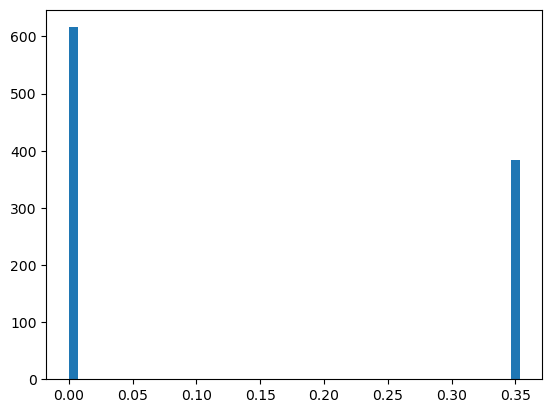

In [42]:
# Evaluation

smoother = SmoothingFunction()

scores = []
for eng,pred in zip(eng_phrases_subset,translations):
    matches = eng2fr_tokens[eng]
    fr_pred = []
    
    # process translations
    trans_pred = preprocess_text(pred['translation_text'])
    fr_pred.append(trans_pred)
    score = sentence_bleu(matches,fr_pred,smoothing_function=smoother.method3)
    scores.append(score)
    
plt.hist(scores,bins=50)
plt.show()

In [43]:
np.mean(scores)

0.13576450198781714

In [44]:
np.random.seed(1)

def print_random_translation():
    i = np.random.choice(len(eng_phrases_subset))
    eng = eng_phrases_subset[i]
    print('EN:',eng)

    translation = translations[i]['translation_text']
    print('FR Translation:',translation)

    matches = eng2fr[eng]
    print('Matches:',matches)

In [45]:
print_random_translation()

EN: tom is a daydreamer
FR Translation: Tom est un rêveur
Matches: ['tom est un reveur']


In [46]:
print_random_translation()

EN: was it all worth it
FR Translation: était-ce que ça en valait la peine ?
Matches: ['estce que ca en valait la peine']


# Method 3: Transformers (Fine Tuning)

In [47]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 870.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 2.1 MB/s eta 0:00:00a 0:00:01


In [48]:
from huggingface_hub import notebook_login
notebook_login()

In [49]:
# Convert dataframe to datasets format

from datasets import load_dataset
df_copy.to_csv("df.csv",index=None) # save dataframe

raw_datasets = load_dataset("csv",data_files="df.csv")
raw_datasets

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 175621
    })
})

In [50]:
# Split raw dataset into train and test

split = raw_datasets['train'].train_test_split(train_size=0.8,seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 140496
    })
    test: Dataset({
        features: ['English words/sentences', 'French words/sentences'],
        num_rows: 35125
    })
})

In [51]:
# Define tokenizer

from transformers import AutoTokenizer

checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [52]:
# Tokenizing function

prefix = "translate English to French: "

def preprocess_function(batch):
    inputs = [prefix + doc for doc in batch["English words/sentences"]]
    targets = [doc for doc in batch["French words/sentences"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [53]:
tokenized_dataset = split.map(preprocess_function, batched=True)
tokenized_dataset

  0%|          | 0/141 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['English words/sentences', 'French words/sentences', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140496
    })
    test: Dataset({
        features: ['English words/sentences', 'French words/sentences', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 35125
    })
})

In [54]:
# Dynamic Padding

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [55]:
# Evaluate

import evaluate
metric = evaluate.load("sacrebleu")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # Evaluate                                                                                  │
│    2                                                                                             │
│    3 import evaluate                                                                             │
│ ❱  4 metric = evaluate.load("sacrebleu")                                                         │
│    5                                                                                             │
│    6                                                                                             │
│    7 def postprocess_text(preds, labels):                                                        │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/evaluate/loading.py:748 in load                          │
│                                                                                                  │
│   745 │   │   ```                                                                                │
│   746 │   """                                                                                    │
│   747 │   download_mode = DownloadMode(download_mode or DownloadMode.REUSE_DATASET_IF_EXISTS)    │
│ ❱ 748 │   evaluation_module = evaluation_module_factory(                                         │
│   749 │   │   path, module_type=module_type, revision=revision, download_config=download_confi   │
│   750 │   )                                                                                      │
│   751 │   evaluation_cls = import_main_class(evaluation_module.module_path)                      │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/evaluate/loading.py:680 in evaluation_module_factory     │
│                                                                                                  │
│   677 │   │   │   │   except Exception as e2:  # noqa: if it's not in the cache, then it doesn   │
│   678 │   │   │   │   │   pass                                                                   │
│   679 │   │   │   if not isinstance(e1, (ConnectionError, FileNotFoundError)):                   │
│ ❱ 680 │   │   │   │   raise e1 from None                                                         │
│   681 │   │   │   raise FileNotFoundError(                                                       │
│   682 │   │   │   │   f"Couldn't find a module script at {relative_to_absolute_path(combined_p   │
│   683 │   │   │   │   f"Module '{path}' doesn't exist on the Hugging Face Hub either."           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/evaluate/loading.py:639 in evaluation_module_factory     │
│                                                                                                  │
│   636 │   │   │   │   │   │   │   │   download_config=download_config,                           │
│   637 │   │   │   │   │   │   │   │   download_mode=download_mode,                               │
│   638 │   │   │   │   │   │   │   │   dynamic_modules_path=dynamic_modules_path,                 │
│ ❱ 639 │   │   │   │   │   │   │   ).get_module()                                                 │
│   640 │   │   │   │   │   │   except ConnectionError:                                            │
│   641 │   │   │   │   │   │   │   pass                                                           │
│   642 │   │   │   │   │   raise FileNotFoundError          

In [ ]:
# Train

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="en_fr_translation",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=5,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
# Predictions

from transformers import pipeline

savedmodel = pipeline("translation_en_to_fr",model="/kaggle/working/en_fr_translation/checkpoint-8500",device=0)

In [ ]:
split['test']

In [ ]:
test_prediction = savedmodel(split['test']['English words/sentences'][:10])

In [ ]:
for i in range(10):
    print("Original English text: ",split['test']['English words/sentences'][i])
    print("Target French text: ",split['test']['French words/sentences'][i])
    print("Translated en --> fr text: ",test_prediction[i]['translation_text'])
    print('\n')

BLEU Score obtained is just 0.34. Spelling errors in data can greatly affect the bleu score. For example: Words "**diront**" and "**direront**" might be pronounced similarly in french but different spellings will give a bleu score of 0 since it compares the n-grams of translated text to original.